# Advanced

* Early Stopping
* Batch Normalization (and Layer Normalization)
* Residual Connections (and Skip Connections)
* Transfer Learning

In [4]:
# imports

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

sns.set_theme(style='whitegrid')

plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

from sklearn.metrics import accuracy_score

from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from introdl.utils import get_device, load_results
from introdl.idlmam import train_network
from introdl.visul import show_image_grid, plot_training_metrics

## Early Stopping

Training for too long can cause overfitting.  One way to avoid this is to add an early stopping strategy to the training loop.  To do that, monitor the loss or another metric on a validation (or test) data set and if that metric doesn't improve for some number of iterations (called the 'patience'), then training is stopped.  Below is a code snippet to show what this could look like:

```python
best_loss = float('inf')
patience = 5
no_improvement = 0

for epoch in range(epochs):
    # Training code here
    
    # Validation code here
    val_loss = calculate_validation_loss(model, val_loader)
    
    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1
        
    if no_improvement >= patience:
        print("Early stopping: No improvement in validation loss for {} epochs".format(patience))

        break
```

## Batch Normalization

Batch normalization is a technique commonly used in deep learning models to improve the training process and the overall performance of the model. It addresses the problem of internal covariate shift, which refers to the change in the distribution of the input values to a layer during training. 

During the training process, as the parameters of the previous layers change, the distribution of the input to the current layer also changes. This makes it difficult for the subsequent layers to learn effectively, as they have to constantly adapt to the changing input distribution. This phenomenon slows down the training process and makes it harder for the model to converge.

Batch normalization helps to mitigate this problem by normalizing the input values to a layer. It calculates the mean and standard deviation of the input values within a mini-batch and then normalizes the values based on these statistics. This normalization step ensures that the input values have zero mean and unit variance.

By normalizing the input values, batch normalization helps to stabilize the training process. It reduces the internal covariate shift, making it easier for the subsequent layers to learn. Additionally, batch normalization acts as a regularizer, reducing the reliance on dropout or other regularization techniques.

Overall, batch normalization improves the training speed, allows for higher learning rates, and makes the model more robust to different input distributions. It has become a standard technique in deep learning models and is widely used in various architectures.

Below we update the `SimpleCNN` model to include batch normalization as discussed in the book.

In [ ]:
# this cell takes several minutes to run, you can run the next cell if you just want to see the results from a previous run
loss_func = nn.CrossEntropyLoss()

device = get_device()
print(device)

epochs = 5
score_funcs = {'ACC':accuracy_score}

for lr in [0.1, 0.01, 0.001]:
    model = SimpleCNN_BN()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    chkpt_file = f'models/model_CIFAR10_SGD_BN_lr{lr}.pt'
    print(f'\nLearning rate: {lr}')
    results = train_network(model,
                  loss_func,
                  train_loader,
                  device=device,
                  val_loader=valid_loader,
                  epochs = epochs,
                  optimizer = optimizer,
                  score_funcs = {'ACC':accuracy_score},
                  checkpoint_file = chkpt_file)
    print('\n')
    display(results)

    print('-------------------------------------------------\n')

mps

Learning rate: 0.1


Epoch: 100%|██████████| 5/5 [01:43<00:00, 20.76s/it]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,14.109251,1.209223,1.041718,0.566975,0.6300
1,1,26.566750,0.871220,0.893992,0.694175,0.6864
2,2,38.980026,0.708121,0.855170,0.751900,0.7017
3,3,51.158059,0.580964,0.846672,0.798475,0.7099
4,4,63.396265,0.469906,0.839198,0.837450,0.7204


-------------------------------------------------


Learning rate: 0.01


Epoch: 100%|██████████| 5/5 [01:43<00:00, 20.74s/it]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,12.436399,1.416964,1.184973,0.512425,0.5840
1,1,24.723942,1.043802,1.002428,0.641850,0.6468
2,2,37.147461,0.893203,0.960565,0.694350,0.6630
3,3,49.749989,0.787534,0.891976,0.730475,0.6850
4,4,62.324024,0.704021,0.855809,0.764400,0.7038


-------------------------------------------------


Learning rate: 0.001


Epoch: 100%|██████████| 5/5 [01:43<00:00, 20.77s/it]

,epoch,total time,train loss,val loss,train ACC,val ACC
0,0,12.735067,1.873765,1.668517,0.357075,0.4399
1,1,25.025771,1.595509,1.515753,0.465725,0.4952
2,2,37.665378,1.469578,1.417901,0.508425,0.5238
3,3,50.561674,1.378704,1.342025,0.540900,0.5464
4,4,63.129136,1.305729,1.286805,0.565775,0.5627


-------------------------------------------------



Batch normalization didn't do anything to prevent overfitting, but it does lead to higher better learning in fewer epochs.  For example, with learning rate $\lambda = 0.01$ we reached validation accuracy of 70% in just 5 epochs versus about 60% when we didn't use batch normalization.  We'll go ahead and train for a total of 30 epochs using $\lambda = 0.01$ just to see how it plays out and for comparing to other approaches.  But we can anticipate that the model will continue to overfit since it's already starting to do so in the first 5 epochs.

In [ ]:
model = SimpleCNN_BN() # create a new instance, will be overwritten by the loaded model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

device = get_device()
print(device)

resume_file = 'models/model_CIFAR10_SGD_BN_lr0.01.pt'
ckpt_file = 'models/model_CIFAR10_SGD_BN_lr0.01_full.pt'
epochs = 25

score_funcs = {'ACC':accuracy_score}

train_network(model,
              loss_func,
              train_loader,
              device=device,
              val_loader=valid_loader,
              epochs = epochs,
              optimizer = optimizer,
              score_funcs = score_funcs,
              checkpoint_file=ckpt_file,
              resume_file=resume_file);

mps


Epoch: 100%|██████████| 25/25 [08:36<00:00, 20.67s/it]


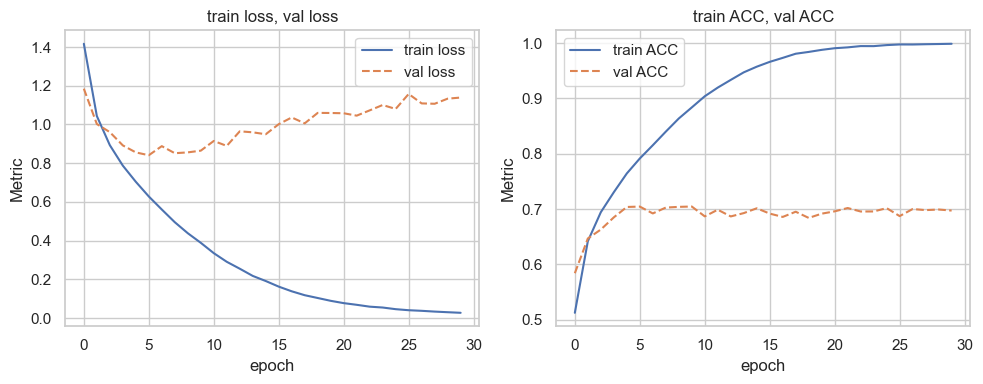

In [ ]:
ckpt_file = 'models/model_CIFAR10_SGD_BN_lr0.01_full.pt'
results_BN = load_results(ckpt_file)

plot_training_metrics(results_BN, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

# you can try the following code for an interactive version of the training metrics plot
# plot_training_metrics_widget(results)

So batch normalization hasn't reduced overfitting or improved the overall accuracy of our model, but it has significantly increased the speed at which our network learns.  The plot below shows the loss and accuracy metric both with and without batch normalization.  When using batch normalization our network reaches maximum validation accuracy in just 5 epochs!

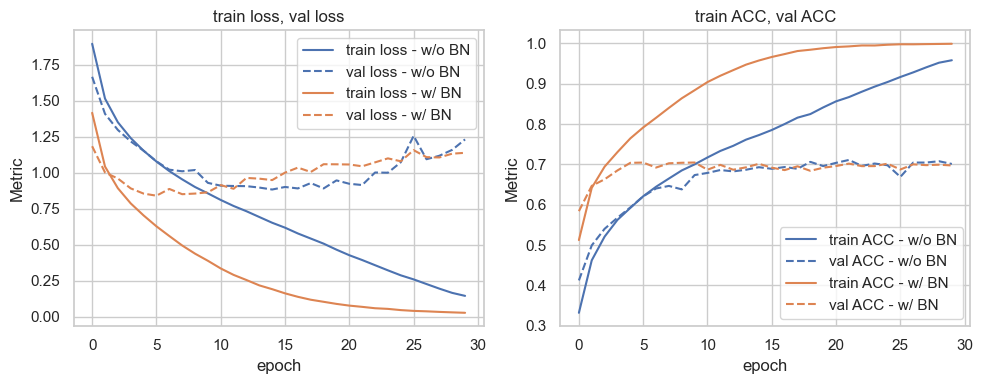

In [ ]:
ckpt_file = 'models/model_CIFAR10_SGD_lr0.01_full.pt'
results = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_SGD_BN_lr0.01_full.pt'
results_BN = load_results(ckpt_file)

plot_training_metrics([results,results_BN], [['train loss', 'val loss'], ['train ACC', 'val ACC']],df_labels=['w/o BN','w/ BN'])

## Residual Connection

The idea of a residual connection is after passing an input through a layer and an activation the input is added to the result.  Why?  It turns out that this will make the loss surface smoother and easier to optimize. 

Nonlinear activation functions are the magic that make neural networks able to learn complex relationships, but they also make it difficult for neural network to model simple relationships.  The simplest relationship is the identity function - what goes in is what comes out.  

Let's set up a toy problem with a very simple network to see what the issue is.  We want the network to learn the identity function so that the outputs of the network match the inputs.  (The idea for this example comes from the book Step by Step, page 618)

We'll create 100 random data points with a single feature (just x values).  The labels are the same as the inputs.


In [5]:
torch.manual_seed(42)
toy_points = torch.randn((100, 1))
toy_dataset = TensorDataset(toy_points, toy_points)
toy_loader = DataLoader( toy_dataset, batch_size=16, shuffle=True)

In [7]:
class Toy(nn.Module): 
    def __init__(self):
        super(Toy, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        out = F.relu(self.linear(x))
        return out

In [ ]:
model = Toy() # create a new instance, will be overwritten by the loaded model
loss_func = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())

device = torch.device('cpu')

ckpt_file = 'models/model_Toy.pt'
epochs = 100

train_network(model,
              loss_func,
              toy_loader,
              device=device,
              epochs = epochs,
              optimizer = optimizer,
              checkpoint_file=ckpt_file);